# Comparaison de modèles Spark ML pour la détection de fraude sur des transactions par carte de crédit
### Etude comparative de différents algorithmes de machine learning disponibles dans Spark ML pour détecter les fraudes dans un jeu de données de transactions par carte de crédit.

> ## Contexte: 
> Le jeu de données utilisé provient de transactions par carte de crédit effectuées par des clients européens en septembre 2013. Il contient des informations sur les transactions, y compris des caractéristiques anonymisées (V1 à V28), le montant de la transaction et une étiquette indiquant si la transaction est frauduleuse (1) ou non (0). Le défi principal réside dans le fait que les fraudes représentent une très petite fraction du total des transactions, ce qui rend la détection difficile.
> Lien vers le dataset : https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

## 0. Installation : 
- Import des bibliothèques nécessaires 
- Installation du dataset si non effectué

In [39]:
!bash -lc 'echo -e "\033[1;34m========== Préparation de l'\''environnement ==========\033[0m"'

# Installation des dépendances dans le kernel courant
%pip install -r ../requirements.txt

# Téléchargement du dataset
!python ../src/import_dataset.py --output ../dataset/raw

========== Préparation de l'environnement ==========
Note: you may need to restart the kernel to use updated packages.
Dataset already exists at ../dataset/raw\creditcard.csv. Skipping download.


## 1. Préparation
- Données: `dataset/raw/creditcard.csv`
- Sorties intermédiaires: `dataset/processed/` (parquet/Delta)
- Objectif: pipeline reproductible.

In [40]:
import sys
import os

# Fix: Set Python executable for Spark workers to match the current environment
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# Spark session
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .appName("cc-fraud")
    .config("spark.driver.host", "127.0.0.1")
    .config("spark.driver.bindAddress", "127.0.0.1")
    # Disable Arrow to prevent worker crashes on Windows
    .config("spark.sql.execution.arrow.pyspark.enabled", "false")
    # Enable fault handler for better error messages
    .config("spark.python.worker.faulthandler.enabled", "true")
    .getOrCreate()
)
spark

In [41]:
# Chargement CSV -> DataFrame Spark
data_path = "../dataset/raw/creditcard.csv"
df = (
    spark.read
    .option("header", True)
    .option("inferSchema", True)
    .csv(data_path)
)

df.describe().show()
df.write.mode("overwrite").parquet("../dataset/processed/raw_parquet") # Sauvegarde parquet brut

+-------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+
|summary|              Time|                  V1|                  V2|                  V3|                  V4|                  V5|                  V6|                  V7|                  V8|                  V9|                 V10|                 V11|                 V12|                 V13|                 V14|                 V15|

# Review du Dataset

{1: 492, 0: 284315}


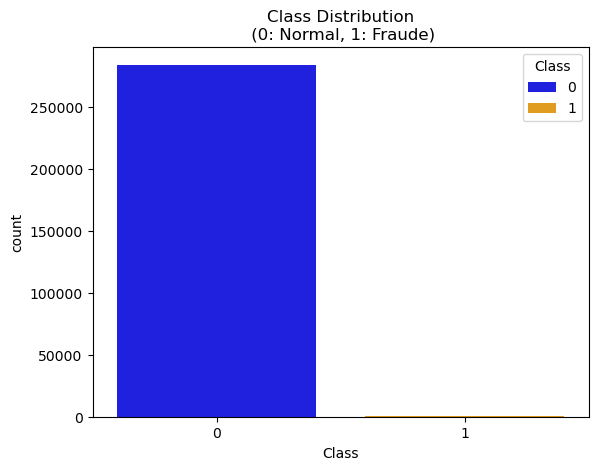

In [42]:
import pandas as pd
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import seaborn as sns


sns.countplot(data=pd.DataFrame(df.select("Class").toPandas()), x='Class', palette=['blue', 'orange'], hue='Class')
plt.title('Class Distribution\n (0: Normal, 1: Fraude)')

class_counts = df.groupBy("Class").count().collect()
print({row['Class']: row['count'] for row in class_counts})



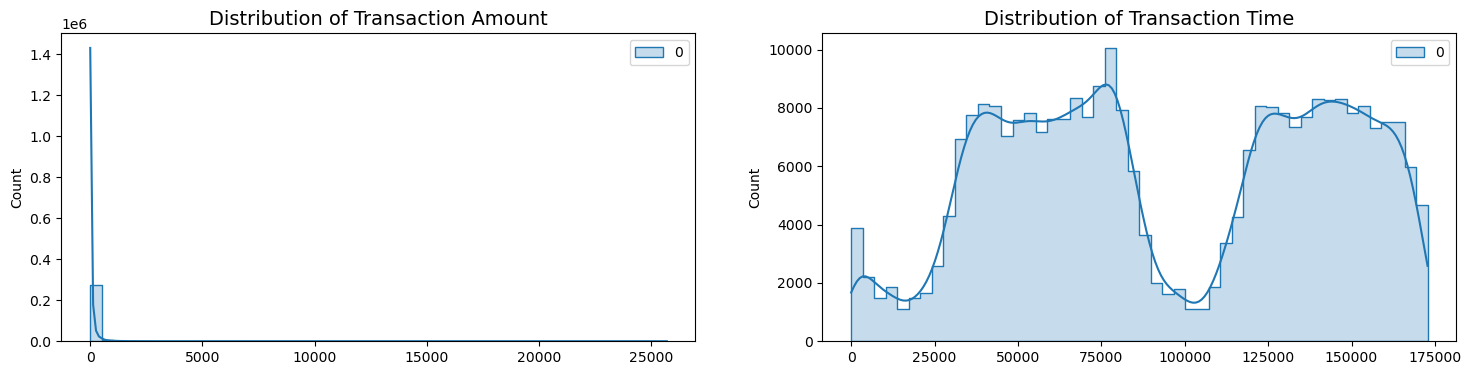

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = pd.DataFrame(df.select("Amount").toPandas()).values
time_val = pd.DataFrame(df.select("Time").toPandas()).values

sns.histplot(data=amount_val, bins=50, ax=ax[0], kde=True, element='step')
sns.histplot(data=time_val, bins=50, ax=ax[1], kde=True, element='step')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[1].set_title('Distribution of Transaction Time', fontsize=14)

plt.show()

C:\Users\pokem\AppData\Local\Temp\ipykernel_16560\4056317550.py:3: RuntimeWarning: divide by zero encountered in log
  log_amount = np.log(amount_val)


Text(0.5, 1.0, 'Log-Transformed Distribution of Transaction Amount')

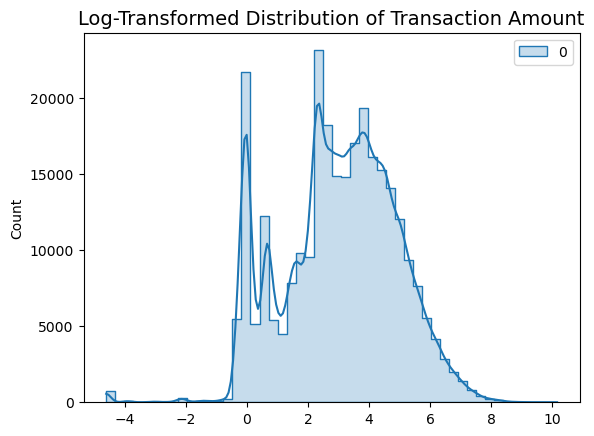

In [44]:
import numpy as np

log_amount = np.log(amount_val)
# Para después dibujar un histograma
sns.histplot(data=log_amount, bins=50, kde=True, element='step')
plt.title('Log-Transformed Distribution of Transaction Amount', fontsize=14)

- Le dataset contient 284,807 transactions, dont seulement 492 sont frauduleuses, ce qui représente environ 0.172% du total. 

Les caractéristiques principales du dataset sont les suivantes :
- "Time" indique le temps écoulé en secondes entre chaque transaction et la première transaction du dataset.
- V1 à V28 sont des résultats de l'analyse en composantes principales (PCA) pour protéger la confidentialité des données. 
- "Amount" indique le montant de chaque transaction 
- "Class" indique si la transaction est frauduleuse (1) ou non (0).

**Un problème majeur est visible:** 

Les données sont très inégalement réparties, cela s'appelle le "skew".
Afin de corriger ce problème, nous allons refaire un échantillonnage des données pour obtenir une répartition 50/50.

# 2. Rééquilibrage des classes

{1: 492, 0: 490}


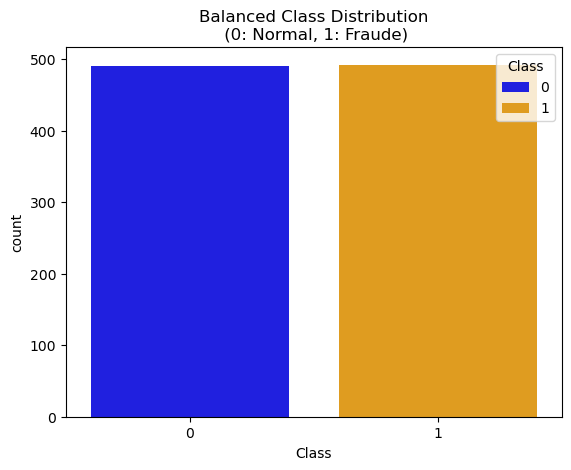

In [45]:
# Sampling random sur les classes pour obtenir un dataset équilibré
fraud_df = df.filter(df.Class == 1)
non_fraud_df = df.filter(df.Class == 0)
non_fraud_sampled_df = non_fraud_df.sample(fraction=fraud_df.count() / non_fraud_df.count(), seed=42)
balanced_df = fraud_df.union(non_fraud_sampled_df)
sns.countplot(data=pd.DataFrame(balanced_df.select("Class").toPandas()), x='Class', palette=['blue', 'orange'], hue='Class')
plt.title('Balanced Class Distribution\n (0: Normal, 1: Fraude)')


class_counts = balanced_df.groupBy("Class").count().collect()
print({row['Class']: row['count'] for row in class_counts})


Regardons la matrice de corrélation des différentes features entre elles.

Pour comparaison, nous gardons aussi la matrice de corrélation avant l'échantillonnage.

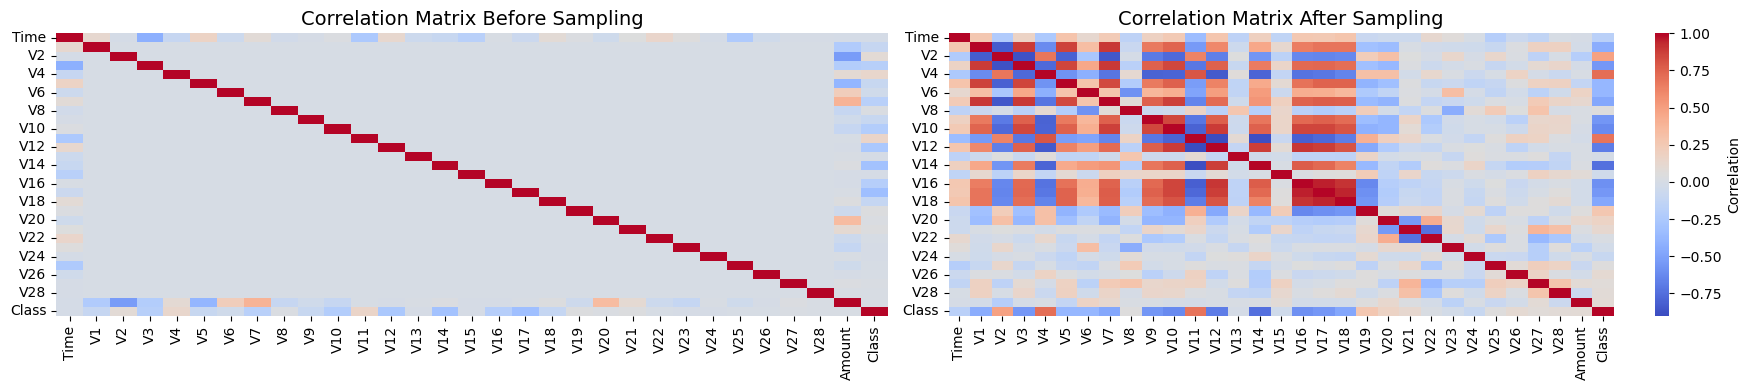

Features highly correlated with Class after sampling:
V4     0.707944
V11    0.681983
V2     0.483757
V19    0.268245
V20    0.174415
Name: Class, dtype: float64
Features highly negatively correlated with Class after sampling:
V9    -0.561965
V16   -0.591866
V10   -0.624939
V12   -0.680533
V14   -0.744281
Name: Class, dtype: float64


In [46]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

corr_matrix_before = df.toPandas().corr()
corr_matrix_after = balanced_df.toPandas().corr()

# Calculate global min and max across both matrices
vmin = min(corr_matrix_before.min().min(), corr_matrix_after.min().min())
vmax = max(corr_matrix_before.max().max(), corr_matrix_after.max().max())

sns.heatmap(corr_matrix_before, ax=ax[0], cmap='coolwarm', vmin=vmin, vmax=vmax, cbar=False)
ax[0].set_title('Correlation Matrix Before Sampling', fontsize=14)

sns.heatmap(corr_matrix_after, ax=ax[1], cmap='coolwarm', vmin=vmin, vmax=vmax, cbar=True, cbar_kws={'label': 'Correlation'})
ax[1].set_title('Correlation Matrix After Sampling', fontsize=14)

plt.tight_layout()
plt.show()

print("Features highly correlated with Class after sampling:")
print(corr_matrix_after.sort_values(by='Class', ascending=False)['Class'][1:6])
print("Features highly negatively correlated with Class after sampling:")
print(corr_matrix_after.sort_values(by='Class', ascending=False)['Class'][-5:])

En modifiant la répartition des classes, la corrélation a énormément changé. Bien qu'au départ les corrélations entre les features et notre classe étaient très faible, l'échantillonnage a révélé des corrélations fortes sur certaines classes.

Il va falloir à présent chercher lesquels regrouper et éliminer.

# 3. Regroupement et élimination des features

### Analyse des features corrélées

Les features suivantes présentent une corrélation avec notre classe cible "Class" (fraude ou non fraude) :
- Corrélations positives :
  - V2
  - V4
  - V11
  - V19
- Corrélations négatives :
  - V10
  - V12
  - V14
  - V17

Nous allons donc d'abord étudier leur distribution afin de décider lesquelles conserver, regrouper ou éliminer.

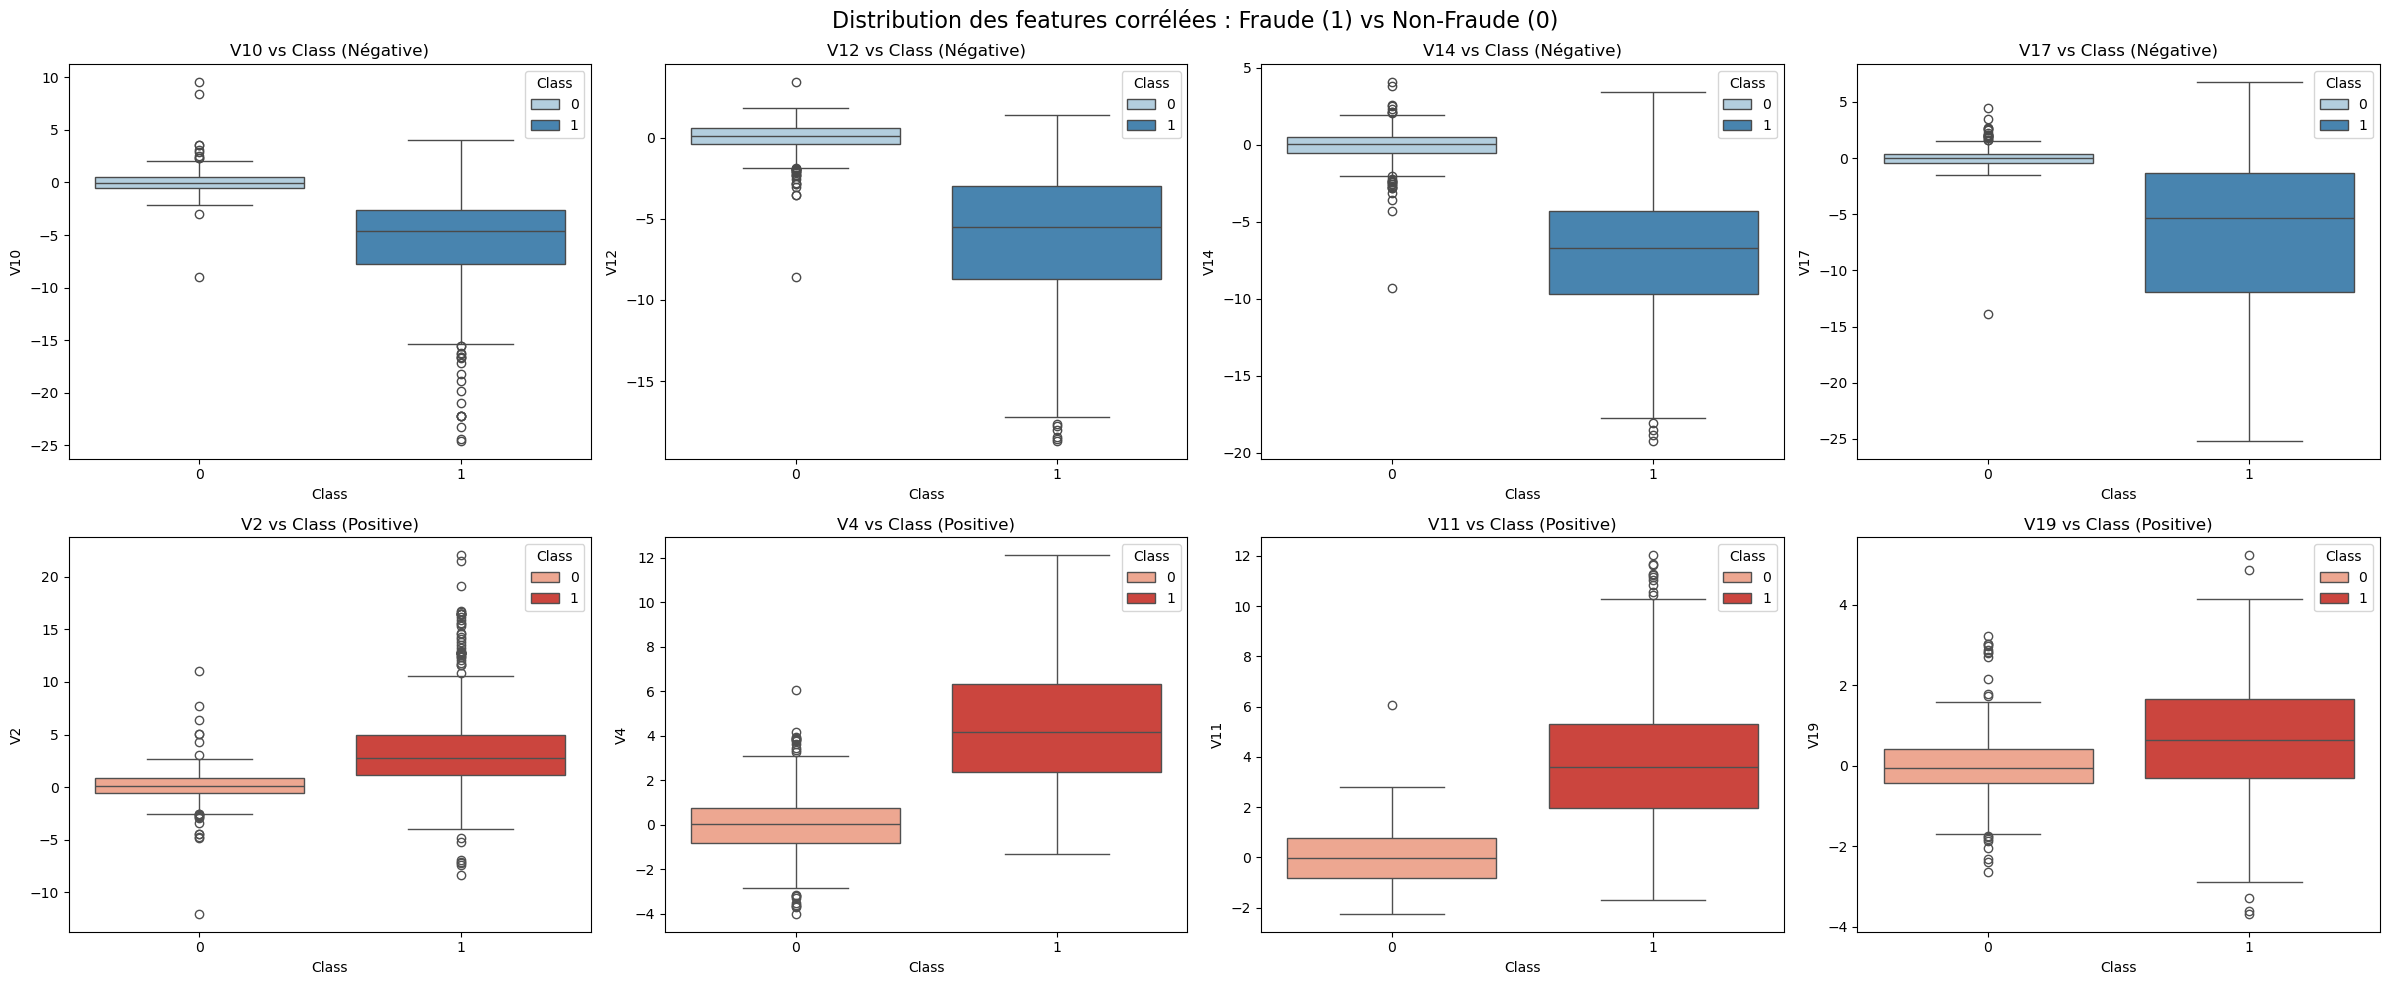

In [47]:
# Conversion en Pandas pour la visualisation
pdf = balanced_df.toPandas()

f, axes = plt.subplots(2, 4, figsize=(24, 10))

# Features à corrélation négative
neg_corrs = ["V10", "V12", "V14", "V17"]
for i, col in enumerate(neg_corrs):
    sns.boxplot(x="Class", y=col, data=pdf, ax=axes[0, i], palette="Blues", hue="Class", dodge=False)
    axes[0, i].set_title(f'{col} vs Class (Négative)')

# Features à corrélation positive
pos_corrs = ["V2", "V4", "V11", "V19"]
for i, col in enumerate(pos_corrs):
    sns.boxplot(x="Class", y=col, data=pdf, ax=axes[1, i], palette="Reds", hue="Class", dodge=False)
    axes[1, i].set_title(f'{col} vs Class (Positive)')

plt.suptitle('Distribution des features corrélées : Fraude (1) vs Non-Fraude (0)', fontsize=16)
plt.tight_layout()
plt.show()

On remarque une séparation nette des distributions entre les classes pour ces variables.
- **V10, V12, V14** : Les fraudes ont des valeurs nettement plus basses.
- **V4, V11** : Les fraudes ont des valeurs plus élevées.

La présence de nombreux **outliers** est également visible. Pour améliorer la robustesse de nos modèles, nous allons supprimer les outliers extrêmes sur les features les plus discriminantes (ex: V14).

Pour supprimer les outliers, nous allons utiliser la méthode de l'écart interquartile (IQR). Nous allons calculer le premier (Q1) et le troisième quartile (Q3) pour chaque feature, puis déterminer l'IQR (Q3 - Q1). Ensuite, nous prendrons un treshold de 1,5 pour déterminer les valeurs en dehors de l'intervalle [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]. Elles seront alors considérées comme des outliers et seront supprimées du dataset.

> Note: Pour info, un outlier est une valeur qui s'écarte significativements de la tendance générale des données. Ils peuvent influencer fortement les résultats des modèles de machine learning et réduire la performance globale. Il faut donc les modérer tout en préservant leur existence dans le dataset.
>
> Note 2: Le seuil influe sur le nombre d'outliers détectés. Un seuil trop petit peut éliminer des données valides, tandis qu'un seuil trop grand peut laisser passer des outliers. Le but est donc de trouver un bon compromis pour garantir la meilleure qualité des données lors de l'apprentissage. En général, un seuil de 1.5 est un bon point de départ.

In [48]:
# Suppression des outliers sur V14, V12, V10 (Features très corrélées) - Approche SQL Pure
from pyspark.sql import functions as F

# 1. Recalcul sécurisé de balanced_df
fraud_count = df.filter(F.col("Class") == 1).count()
non_fraud_count = df.filter(F.col("Class") == 0).count()
fraction = fraud_count / non_fraud_count

# Sampling manuel via rand()
balanced_df = df.filter(F.col("Class") == 1).union(
    df.filter((F.col("Class") == 0) & (F.rand(seed=42) < fraction))
)

features_to_clean = ['V14', 'V12', 'V10']

for col_name in features_to_clean:
    # Calcul des quartiles via SQL (percentile_approx) sur les fraudes uniquement
    quantiles_row = balanced_df.filter(F.col("Class") == 1).selectExpr(
        f"percentile_approx({col_name}, 0.25) as q1",
        f"percentile_approx({col_name}, 0.75) as q3"
    ).collect()[0]

    q1 = float(quantiles_row['q1'])
    q3 = float(quantiles_row['q3'])
    iqr = q3 - q1
    cut_off = iqr * 1.5
    lower, upper = q1 - cut_off, q3 + cut_off

    print(f'{col_name} Outliers: < {lower:.2f} ou > {upper:.2f}')

    initial_count = balanced_df.count()
    
    # Filtrage: on retire les outliers SEULEMENT pour la classe Fraude (1)
    balanced_df = balanced_df.filter(
        ~((F.col("Class") == 1) & ((F.col(col_name) > upper) | (F.col(col_name) < lower)))
    )
    
    final_count = balanced_df.count()
    print(f'Nombre d\'outliers {col_name} supprimés: {initial_count - final_count}')

print(f'Nouveau nombre de lignes total: {balanced_df.count()}')

V14 Outliers: < -18.06 ou > 3.98
Nombre d'outliers V14 supprimés: 3
V12 Outliers: < -17.35 ou > 5.77
Nombre d'outliers V12 supprimés: 4
V10 Outliers: < -14.98 ou > 4.96
Nombre d'outliers V10 supprimés: 25
Nouveau nombre de lignes total: 950


On retrace les boxplots après suppression des outliers sur V14. Pour bien vérifier la suppression des outliers:

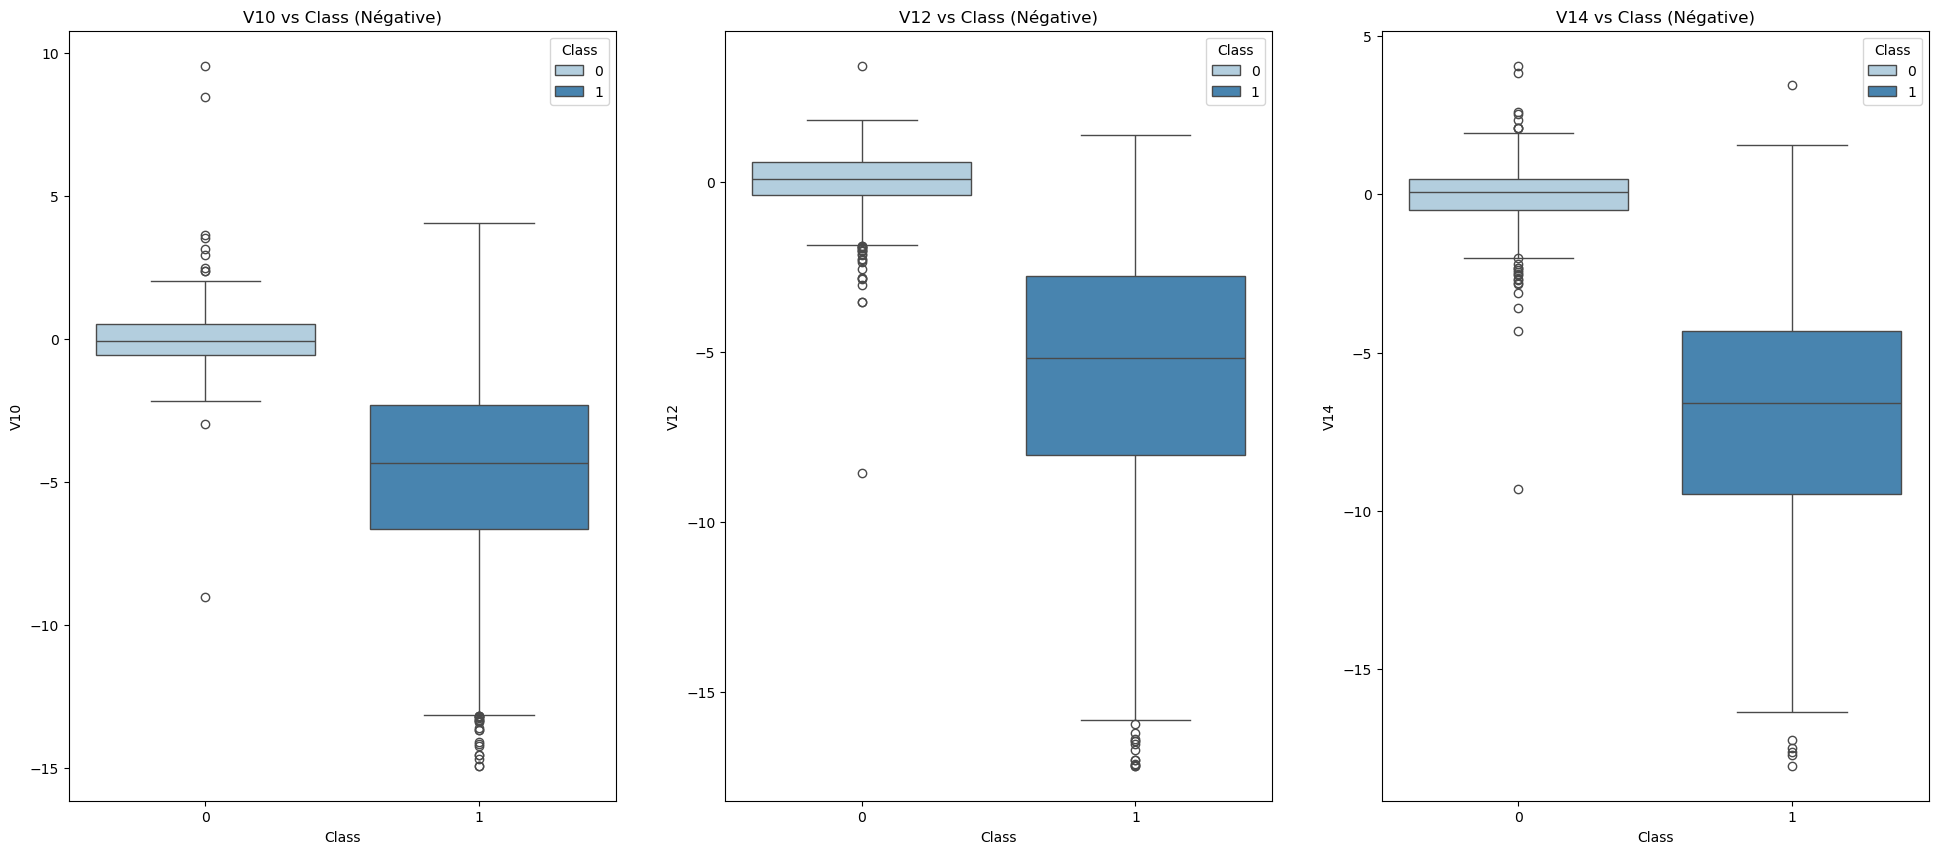

In [65]:
pdf = balanced_df.toPandas()

f, axes = plt.subplots(1, 3, figsize=(24, 10))

# Features à corrélation négative
neg_corrs = ["V10", "V12", "V14"]
for i, col in enumerate(neg_corrs):
    sns.boxplot(x="Class", y=col, data=pdf, ax=axes[i], palette="Blues", hue="Class", dodge=False)
    axes[i].set_title(f'{col} vs Class (Négative)')

Et voilà!

Maintenant que nous avons équilibré les classes, nous pouvons procéder à l'entraînement et à l'évaluation des modèles de machine learning.

# 4. Modélisation

Nous allons chercher à comparer plusieurs modèles de machine learning disponibles dans Spark ML pour détecter les fraudes dans notre dataset rééquilibré.

Pour ce premier modèle, nous allons utiliser une régression logistique avec des poids de classe pour atténuer le déséquilibre.

## Création du Pipeline
D'abord, nous séparons les données en ensembles d'entraînement et de test (80/20) :

In [50]:
train_df, test_df = balanced_df.randomSplit([0.8, 0.2], seed=42)
train_df.cache(); test_df.cache()
print(train_df.count(), test_df.count())

751 199


> On prépare les pipelines des features :
> - `VectorAssembler` pour assembler les features en un vecteur unique
> - `StandardScaler` pour normaliser les features
> - Et finalement, on assemble tout cela dans un Pipeline Spark ML via `Pipeline`.

In [51]:
# Pipeline de features
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
feature_cols = [c for c in balanced_df.columns if c not in ("Class",)]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")
scaler = StandardScaler(inputCol="features_raw", outputCol="features")
pipeline_feats = Pipeline(stages=[assembler, scaler])
pipeline_feats

Pipeline_972a781db3a1

## Premier modèle : Régression Logistique
Entraînement du premier modèle avec validation croisée pour optimiser les hyperparamètres.

Nous configurons une **régression logistique** avec :
- **RegParam** : force de régularisation (évite le surapprentissage)
- **ElasticNetParam** : mix entre régularisation L1 et L2
    - 0.0 = régularisation L2 (Ridge)
    - 0.5 = combinaison L1 + L2 (Elastic Net)
    - 1.0 = régularisation L1 (Lasso)

La **validation croisée** teste automatiquement les meilleures combinaisons de ces paramètres sur le jeu d'entraînement, puis évalue les performances avec la métrique **AUPRC** (Area Under Precision-Recall Curve).

On évalue ensuite le modèle via les métriques de precision, recall et le F1-score sur le jeu de test. 


In [52]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import time

start = time.time()
lr = LogisticRegression(featuresCol="features", labelCol="Class")
param_grid = (ParamGridBuilder()
    .addGrid(lr.regParam, [0.01, 0.1])
    .addGrid(lr.elasticNetParam, [0.0, 0.5])
    .build())

evaluator = BinaryClassificationEvaluator(labelCol="Class", metricName="areaUnderPR")
cv = CrossValidator(estimator=lr, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)
full_pipeline = Pipeline(stages=[assembler, scaler, cv])
cv_model = full_pipeline.fit(train_df)
lr_preds = cv_model.transform(test_df)
lr_auprc = evaluator.evaluate(lr_preds)
lr_time = time.time() - start
print("LR AUPRC:", lr_auprc, ", Time:", lr_time)

LR AUPRC: 0.9606293957888382 , Time: 48.73323345184326


Best threshold for F1-Score = 0.51 | Recall=0.923 | Precision=0.966 | F1=0.944


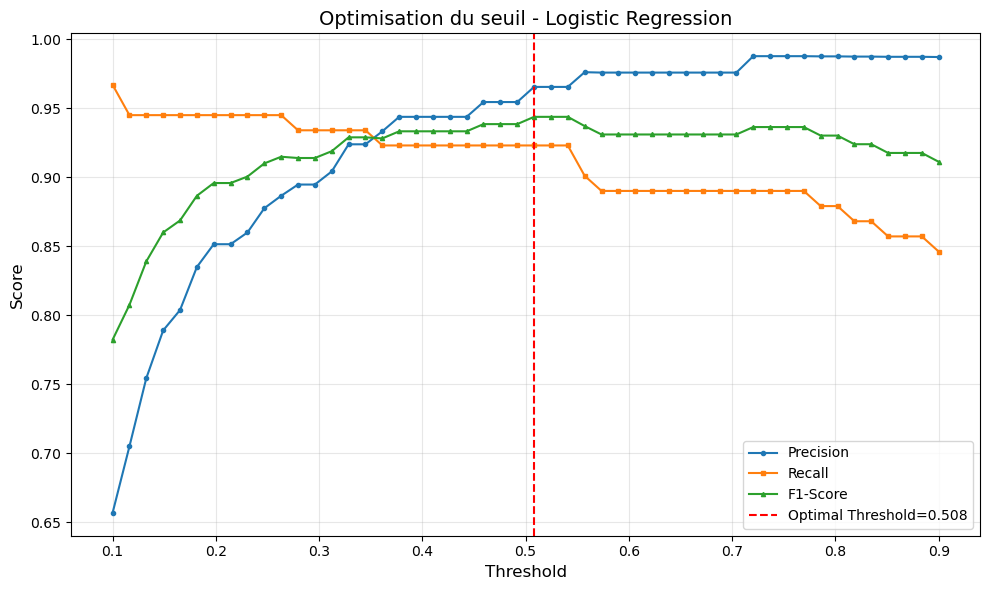

In [53]:
# Évaluation complémentaire et seuil
from pyspark.ml.functions import vector_to_array
lr_preds = lr_preds.withColumn("score", vector_to_array(F.col("probability"))[1])

thresholds = np.linspace(0.1, 0.9, 50)
results = {'threshold': [], 'precision': [], 'recall': [], 'f1': []}

for threshold in thresholds:
    preds_thresh = lr_preds.withColumn("prediction_thresh", (F.col("score") >= threshold).cast("double"))
    tp = preds_thresh.filter((F.col("prediction_thresh") == 1) & (F.col("Class") == 1)).count()
    fp = preds_thresh.filter((F.col("prediction_thresh") == 1) & (F.col("Class") == 0)).count()
    fn = preds_thresh.filter((F.col("prediction_thresh") == 0) & (F.col("Class") == 1)).count()
    
    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    f1 = 2 * precision * recall / (precision + recall + 1e-9)
    
    for key, value in zip(['threshold', 'precision', 'recall', 'f1'], [threshold, precision, recall, f1]):
        results[key].append(value)
    # print(f"Treshold={threshold:.1f} | Precision={precision:.3f} | Recall={recall:.3f} | F1={f1:.3f}")

best = max(zip(results['threshold'], results['precision'], results['recall'], results['f1']), key=lambda x: x[3])  # x = (threshold, precision, recall, f1)
best_threshold, best_precision, best_recall, best_f1 = best
print(f"Best threshold for F1-Score = {best_threshold:.2f} | Recall={best_recall:.3f} | Precision={best_precision:.3f} | F1={best_f1:.3f}")
# Appliquer ce meilleur seuil pour une colonne de prédiction dédiée
lr_preds = lr_preds.withColumn("prediction_best_recall", (F.col("score") >= F.lit(best_threshold)).cast("double"))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(results['threshold'], results['precision'], label='Precision', marker='o', markersize=3)
ax.plot(results['threshold'], results['recall'], label='Recall', marker='s', markersize=3)
ax.plot(results['threshold'], results['f1'], label='F1-Score', marker='^', markersize=3)
ax.axvline(best_threshold, color='red', linestyle='--', label=f'Optimal Threshold={best_threshold:.3f}')
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title(f'Optimisation du seuil - Logistic Regression', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

> ### Pourquoi avoir mis plusieurs thresholds ?
>
> En ajustant le seuil de décision, on peut optimiser le compromis entre précision et rappel, ce qui est crucial dans les scénarios de détection de fraude où les faux négatifs peuvent être coûteux. 
>
> Par défaut, on cherche à  identifier le seuil qui maximise le F1-score, offrant ainsi un équilibre optimal entre la détection des fraudes et la minimisation des fausses alertes.

<!-- Cependant, dans le cadre de la détection de fraude, il est plus important d'avoir des faux positifs que des faux négatifs. On prendra donc un seuil plus bas pour maximiser le rappel, même si cela peut réduire légèrement la précision.-->


## Visualisation des résultats
### Courbe Precision-Recall
La courbe Precision-Recall illustre le compromis entre la précision et le rappel pour différents seuils.


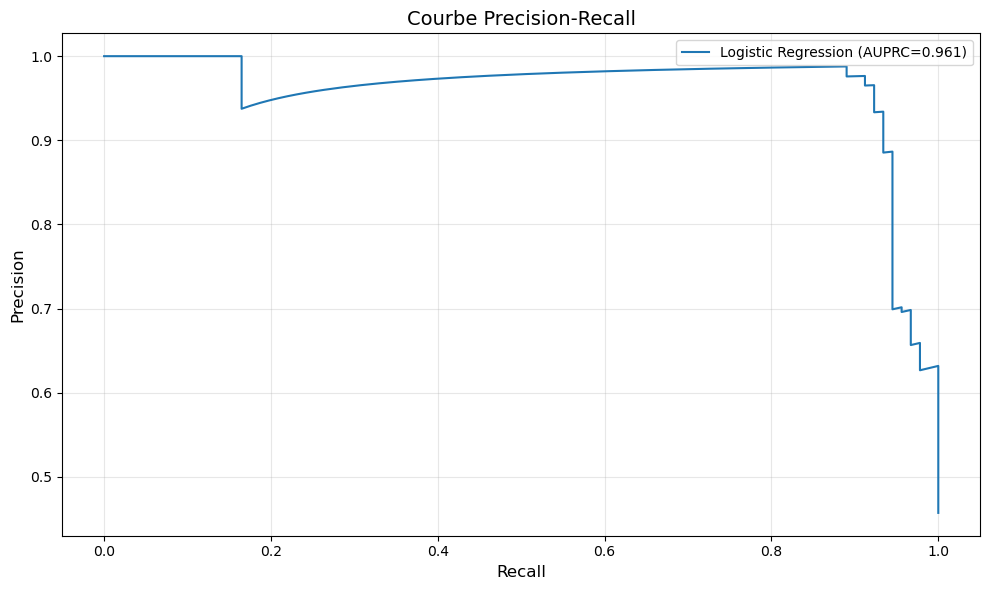

In [54]:
from sklearn.metrics import precision_recall_curve, auc

# Get predictions from the logistic regression model (already in preds variable)
lr_pdf = lr_preds.select("Class", "score").toPandas()

fig, ax = plt.subplots(figsize=(10, 6))
precision_curve, recall_curve, _ = precision_recall_curve(lr_pdf['Class'], lr_pdf['score'])
auprc = auc(recall_curve, precision_curve)
ax.plot(recall_curve, precision_curve, label=f"Logistic Regression (AUPRC={auprc:.3f})")

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Courbe Precision-Recall', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Courbe ROC
La courbe ROC (Receiver Operating Characteristic) montre la performance du modèle en traçant le taux de vrais positifs (TPR) contre le taux de faux positifs (FPR) à différents seuils de classification.

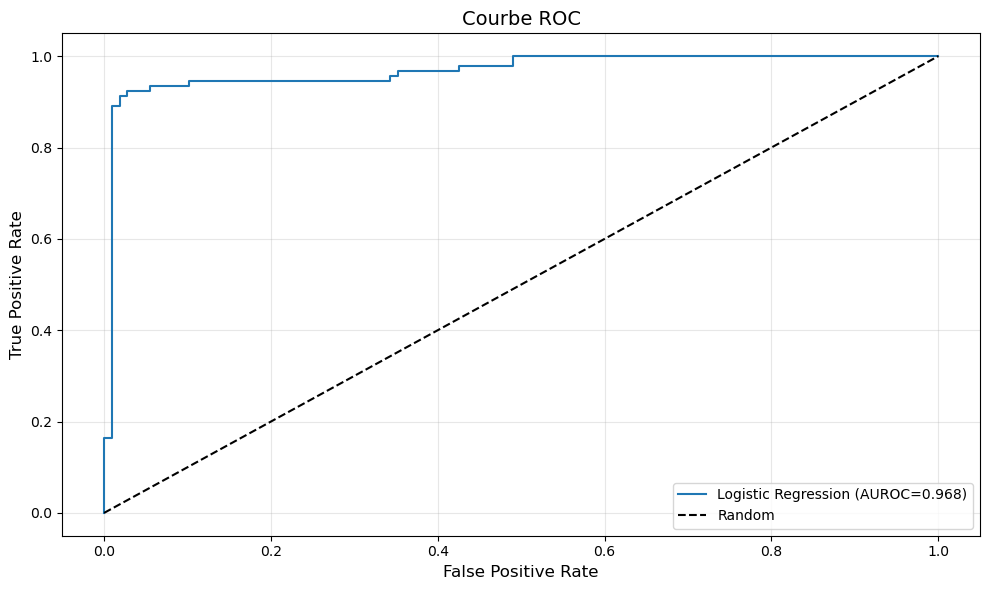

In [55]:
from sklearn.metrics import roc_curve, roc_auc_score

fig, ax = plt.subplots(figsize=(10, 6))
fpr, tpr, thresholds = roc_curve(lr_pdf['Class'], lr_pdf['score'])
auroc = roc_auc_score(lr_pdf['Class'], lr_pdf['score'])
ax.plot(fpr, tpr, label=f"Logistic Regression (AUROC={auroc:.3f})")

ax.plot([0, 1], [0, 1], 'k--', label='Random')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('Courbe ROC', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Matrice de confusion
La matrice de confusion permet de visualiser les performances du modèle en termes de vrais positifs, faux positifs, vrais négatifs et faux négatifs.

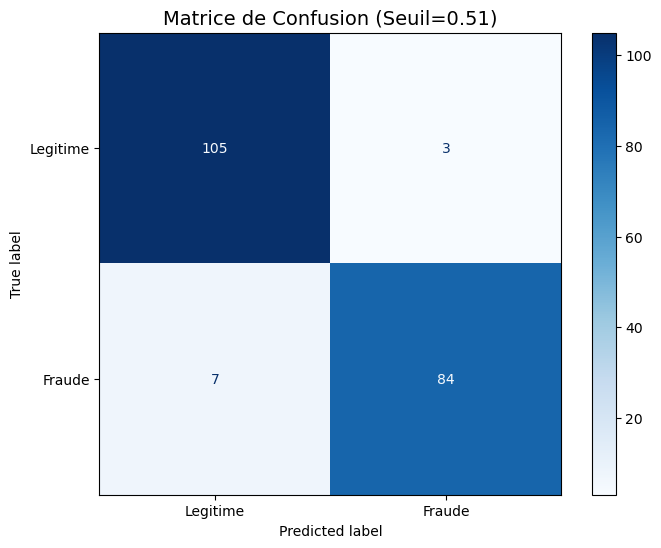

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(lr_pdf['Class'], (lr_pdf['score'] >= best_threshold).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legitime', 'Fraude'])
disp.plot(ax= ax, cmap='Blues', values_format='d')
plt.title(f'Matrice de Confusion (Seuil={best_threshold:.2f})', fontsize=14)
plt.show()

# Comparaison avec d'autres modèles 

Bien que le modèle de régression logistique ait montré de bonnes performances, il est important d'explorer d'autres algorithmes de machine learning pour s'assurer que nous utilisons le modèle le plus efficace pour la détection de fraude.

Nous étudierons notamment les modèles suivants :
- RandomForestClassifier
- GBTClassifier (Gradient Boosted Trees)

Puis, nous tracerons plusieurs métriques sur les 3 modèles:
- Courbe Precision-Recall (avec AUPRC)
- Courbe ROC (avec ROC-AUC)
- F1-Score
- Distribution des scores de prédiction par classe
- Matrice de confusion

### Entrainements des modèles
Nous allons entraîner les modèles Random Forest et Gradient Boosted Trees en utilisant des pipelines similaires à celui de la régression logistique, en ajustant les hyperparamètres spécifiques à chaque modèle.

In [57]:
# RandomForestClassifier
from pyspark.ml.classification import RandomForestClassifier

start = time.time()
rf = RandomForestClassifier(featuresCol="features", labelCol="Class", numTrees=20, seed=42)
rf_pipeline = Pipeline(stages=[assembler, scaler, rf])
rf_model = rf_pipeline.fit(train_df)
rf_preds = rf_model.transform(test_df)
rf_preds = rf_preds.withColumn("score", vector_to_array(F.col("probability"))[1])
rf_auprc = evaluator.evaluate(rf_preds)
rf_time = time.time() - start
print(f"RF AUPRC: {rf_auprc:.4f}, Time: {rf_time:.2f}s")

RF AUPRC: 0.9631, Time: 2.15s


In [58]:
# GradientBoostedTreeClassifier
from pyspark.ml.classification import GBTClassifier

start = time.time()
gbt = GBTClassifier(featuresCol="features", labelCol="Class", maxIter=20, seed=42)
gbt_pipeline = Pipeline(stages=[assembler, scaler, gbt])
gbt_model = gbt_pipeline.fit(train_df)
gbt_preds = gbt_model.transform(test_df)
gbt_preds = gbt_preds.withColumn("score", vector_to_array(F.col("probability"))[1])
gbt_auprc = evaluator.evaluate(gbt_preds)
gbt_time = time.time() - start

print(f"GBT AUPRC: {gbt_auprc:.4f}, Time: {gbt_time:.2f}s")

GBT AUPRC: 0.9667, Time: 12.74s


### Visualisation des métriques

A présent, nous allons visualiser les performances des différents modèles à l'aide de diverses métriques.

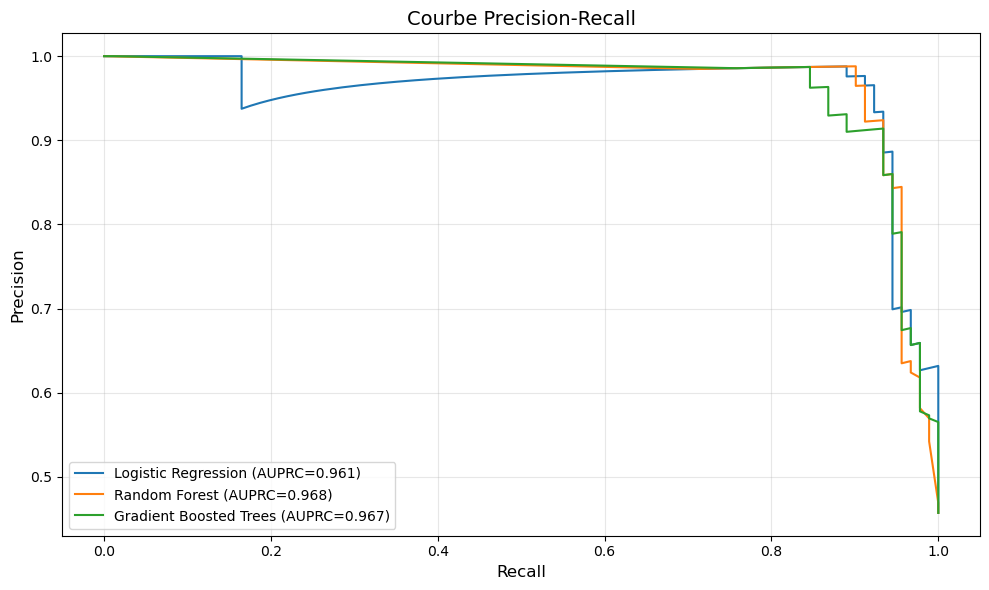

In [59]:
# Courbe Precision-Recall pour les trois modèles
predictions = {
    "Logistic Regression": lr_pdf,
    "Random Forest": rf_preds.select("Class", "score").toPandas(),
    "Gradient Boosted Trees": gbt_preds.select("Class", "score").toPandas()
}

fig, ax = plt.subplots(figsize=(10, 6))
for name, pdf in predictions.items():
    precision, recall, thresholds = precision_recall_curve(pdf['Class'], pdf['score'])
    auprc = auc(recall, precision)
    ax.plot(recall, precision, label=f"{name} (AUPRC={auprc:.3f})")

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Courbe Precision-Recall', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

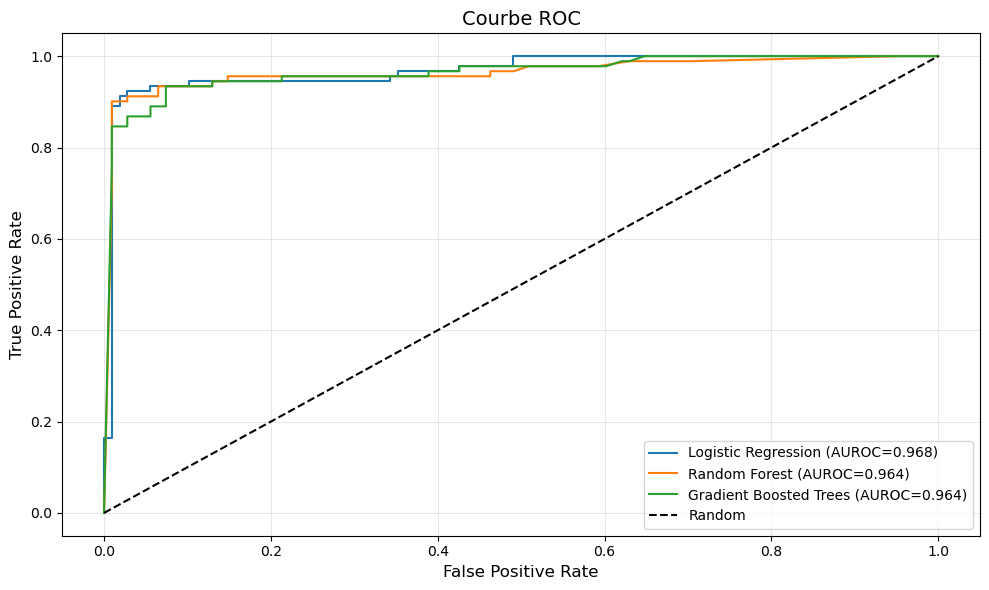

In [60]:
# Courbe ROC pour tous les modèles
fig, ax = plt.subplots(figsize=(10, 6))
for name, pdf in predictions.items():
    fpr, tpr, thresholds = roc_curve(pdf['Class'], pdf['score'])
    auroc = roc_auc_score(pdf['Class'], pdf['score'])
    ax.plot(fpr, tpr, label=f"{name} (AUROC={auroc:.3f})")
ax.plot([0, 1], [0, 1], 'k--', label='Random')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('Courbe ROC', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [61]:
# F1-Score pour tous les modèles
best_f1_model = {}
best_thresh_model = {}

for name, pdf in predictions.items():
    precision, recall, thresholds = precision_recall_curve(pdf['Class'], pdf['score'])
    
    # Calcul du F1 pour chaque seuil possible
    numerator = 2 * precision * recall
    denominator = precision + recall
    
    f1_scores = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)
    
    # Trouver le meilleur F1
    best_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_idx]
    
    best_thresh = thresholds[best_idx] if best_idx < len(thresholds) else 1.0
    
    best_f1_model[name] = best_f1
    best_thresh_model[name] = best_thresh
    print(f"{name:<25} | F1-Score: {best_f1:.4f}     | Treshold trouvé: {best_thresh:.4f}")

Logistic Regression       | F1-Score: 0.9438     | Treshold trouvé: 0.5503
Random Forest             | F1-Score: 0.9425     | Treshold trouvé: 0.6484
Gradient Boosted Trees    | F1-Score: 0.9239     | Treshold trouvé: 0.3396


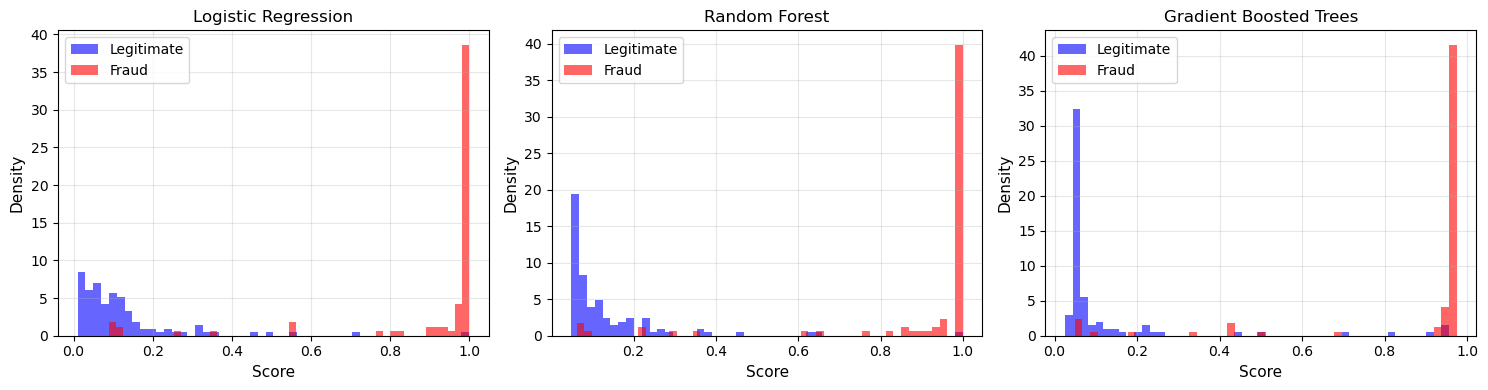

In [62]:
# Distribution des scores par classe
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, (name, pdf) in enumerate(predictions.items()):
    ax = axes[idx]
    legit = pdf[pdf['Class'] == 0]['score']
    fraud = pdf[pdf['Class'] == 1]['score']
    ax.hist(legit, bins=50, alpha=0.6, label='Legitimate', color='blue', density=True)
    ax.hist(fraud, bins=50, alpha=0.6, label='Fraud', color='red', density=True)
    ax.set_xlabel('Score', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(name, fontsize=12)
    ax.legend()
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

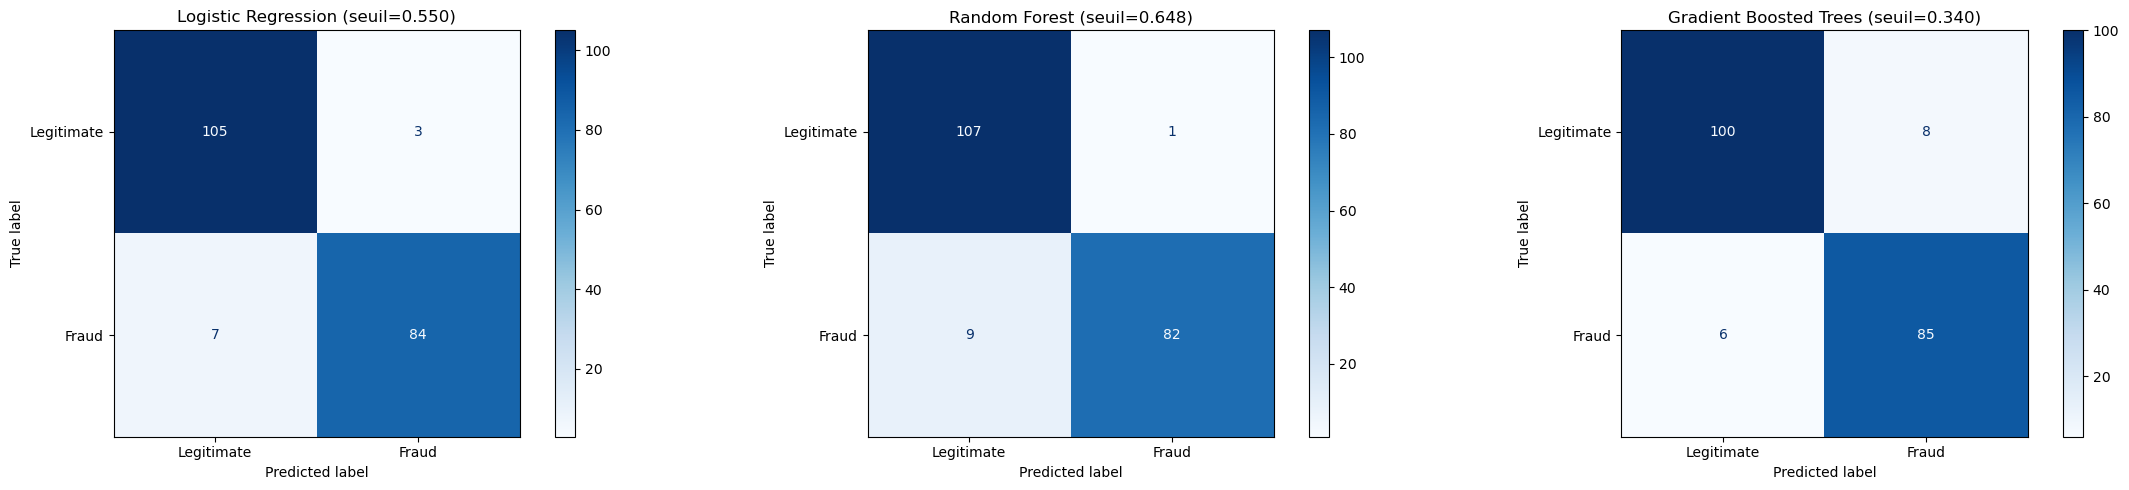

In [63]:
# Matrices de confusion

fig, axes = plt.subplots(1, 3, figsize=(23, 5))
for i, (name, pdf)  in enumerate(predictions.items()):
    y_pred_opt = (pdf['score'] >= best_thresh_model[name]).astype(int)
    cm = confusion_matrix(pdf['Class'], y_pred_opt)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legitimate', 'Fraud'])
    disp.plot(ax=axes[i], cmap='Blues', values_format='d')
    axes[i].set_title(f'{name} (seuil={best_thresh_model[name]:.3f})', fontsize=12)
plt.tight_layout()
plt.show()


Ces données nous permettent dee savoir deux choses:
- Globalement, les modèles sont équivalent en termes de performance AUPRC et ROC-AUC.
- Cependant, en regardant la distribution des scores, on remarque que le modèle GBT sépare mieux les classes, ce qui est crucial pour la détection de fraude.

*Ce choix est aussi appuyé par les matrices de confusion montrant que GBT parvient mieux à trouver les fraudes, malgré quelques faux positifs. Dans le cadre de la recherche de fraudes, il vaut mieux en détecter trop qu'en laisser passer.*

Pour la suite, nous pourrons choisir le modèle GBT pour sa meilleure séparation des classes, ce qui est essentiel dans le contexte de la détection de fraude où la distinction claire entre transactions frauduleuses et non frauduleuses est primordiale.

## 6. Export et scoring

Cette dernière partie se concentre sur l'exportation du modèle entraîné et la création d'un script de scoring pour évaluer de nouvelles données.

On cherchera à :
- Sauver `full_pipeline` entraîné (`PipelineModel.save`).
- Script batch de scoring : charger modèle, lire parquet, écrire scores.

In [64]:
# Sauvegarder le meilleur modèle (GBT )
best_model_name = "gbt_pipeline" if gbt_auprc >= max(evaluator.evaluate(gbt_preds), gbt_auprc) else ("rf_pipeline" if rf_auprc > evaluator.evaluate(rf_preds) else "lr_pipeline")
best_pipeline = gbt_pipeline if best_model_name == "gbt_pipeline" else (rf_pipeline if best_model_name == "rf_pipeline" else full_pipeline)
best_model = gbt_model if best_model_name == "gbt_pipeline" else (rf_model if best_model_name == "rf_pipeline" else cv_model)

model_path = f"../models/{best_model_name}"

# Nettoyage préalable du dossier (nécessaire pour éviter les conflits de fichiers sur Windows)
import shutil
import os
if os.path.exists(model_path):
    shutil.rmtree(model_path)

print(f"Sauvegarde du meilleur modèle ({best_model_name}) à {model_path}")

# FIX: Sauvegarde via l'objet Java directement pour éviter le crash du worker Python
abs_path = os.path.abspath(model_path)
# On utilise le préfixe file:/// pour Windows
java_path = "file:///" + abs_path.replace("\\", "/")

best_model._to_java().save(java_path)
print("Modèle sauvegardé avec succès.")

Sauvegarde du meilleur modèle (gbt_pipeline) à ../models/gbt_pipeline
Modèle sauvegardé avec succès.
